In [ ]:
import os
import torch
from torch import optim, nn, utils, Tensor
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(0);

13 32 5408
tensor([[0.0732, 0.0746, 0.1118, 0.1378, 0.0979, 0.1004, 0.1027, 0.1034, 0.0946,
         0.1036]])


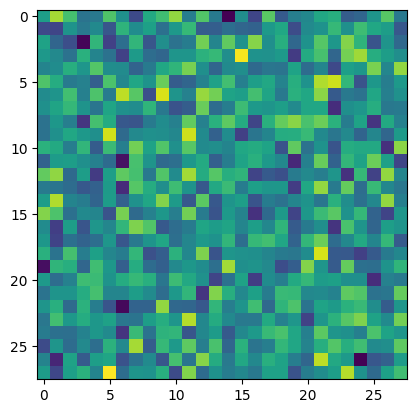

In [ ]:
class NClassifier(torch.nn.Module):

    def __init__(self, n_classes):
      super(NClassifier, self).__init__()

      self.encoder = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, n_classes))

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_hat = self.encoder(x)
        return y_hat

class CNNClassifier(torch.nn.Module):
    # conv_layers: an array of arrays like: [[1,32, 5],[32,32, 5],[32,64, 5]]   the third element of each array is the kernel_size
    # interlayer_activation_fns: actual nn.functional that will be called after each convolution
    # fc_layers: an array of arrays like: [[3*3*64,256],[256,n_classes]]

    # self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    # self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
    # self.conv3 = nn.Conv2d(32,64, kernel_size=5)
    # self.fc1 = nn.Linear(3*3*64, 256)
    # self.fc2 = nn.Linear(256, n_classes)
    def __init__(self,img_dim, conv_layers,interlayer_activation_fns, fc_layers, n_classes=10):
        super(CNNClassifier, self).__init__()
        self.interlayer_activation_fns=interlayer_activation_fns
        self.conv_layers=conv_layers
        self.fc_layers=fc_layers

        self.nc = img_dim
        for idx,conv_layer in enumerate(conv_layers):
          setattr(self,"conv"+str(idx),nn.Conv2d(conv_layer[0],conv_layer[1],kernel_size=conv_layer[2]))
          self.nc+=-conv_layer[2] + 1   # - r i.e. kernel_size

          for el in interlayer_activation_fns:
            if(el[0]=="max_pool2d"):
              self.nc=int(self.nc/el[1])
              if(self.nc<0):
                raise ValueError("Alert!: resulting Feature map will be less than 0")

        for idx,fc_layer in enumerate(fc_layers):
          input2nn=fc_layer[0]
          if(idx==0):
            input2nn=int((self.nc*self.nc)*conv_layers[-1][1])
            print(self.nc, conv_layers[-1][1],input2nn)
          setattr(self,"fc"+str(idx),nn.Linear(input2nn,fc_layer[1]))

    def forward(self, x):
        # New Feature Map size is n_c = ((n_i + 2P - r)/s) + 1
        for idx,conv_layer in enumerate(self.conv_layers):
          conv=getattr(self,"conv"+str(idx))
          x=conv(x)
          for el in self.interlayer_activation_fns:
            if(el[0]=="relu"):
              x=F.relu(x)

            if(el[0]=="max_pool2d"):
              x=F.max_pool2d(x,el[1])

            if(el[0]=="dropout"):
              x=F.dropout(x,training=self.training)

        x=x.view(-1,int((self.nc*self.nc)*self.conv_layers[-1][1]))

        for idx,fc_layer in enumerate(self.fc_layers):
          fc=getattr(self,"fc"+str(idx))
          x=fc(x)

        return F.softmax(x, dim=1) if self.training else x            # Softmax is called for inference only, since CrossEntropyLoss already computes it

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x1):
        x = F.relu(self.conv1(x1))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
        return x

n_classes=10
img_dim=28
model=CNNClassifier(img_dim,[[1,32, 3]],[["relu"],["max_pool2d",2]],[[1,256],[256,n_classes]],n_classes)

# Is this random call affecting RNG?
random_img=torch.randn(1,28,28)
result=model(random_img).detach()
print(result)
plt.imshow(random_img.permute(1,2,0))
plt.show()

In [ ]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_classes=10
model=CNNClassifier(img_dim,[[1,32, 3]],[["relu"],["max_pool2d",2]],[[1,256],[256,n_classes]],n_classes)
model=model.to(device)
mnist_train = MNIST(os.getcwd(), train=True, download=True)

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(0.5, 0.5)
                              ]
                             )
mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transform)
mnist_train, mnist_val = random_split(mnist_train, [55000, 5000])

# Data Loaders
mnist_train = DataLoader(mnist_train, batch_size=64)
mnist_val = DataLoader(mnist_val, batch_size=64)

# ADAM Optimizer
params = model.parameters()
optimizer = torch.optim.Adam(params, lr=1e-3)

13 32 5408


100%|██████████| 9.91M/9.91M [00:00<00:00, 54.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.75MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.99MB/s]


# Assignment: Training with Early Stopping

In [ ]:
def train(model: torch.nn.Module,
          training_set: DataLoader,
          validation_set: DataLoader,
          num_epochs: int = 100,
          patience: int = 5,
          plot: bool = False,
          device: torch.device | None = None):
  if device is None:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  model.to(device)

  best_val_loss = float('inf')
  epochs_without_improvement = 0
  best_model = None

  val_losses=[]
  epoch_losses = []

  epoch = 0
  while epoch < num_epochs and epochs_without_improvement < patience:
    epoch += 1

    # TRAINING
    model.train()
    train_loss = 0
    n = 0
    for x, y in training_set:
      n += 1
      x, y = x.to(device), y.to(device)
      y_hat = model(x)
      loss = nn.functional.cross_entropy(y_hat, y)
      train_loss += loss.item()
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    epoch_losses.append(train_loss / n)

    # VALIDATION
    model.eval()
    val_loss = 0
    n = 0
    with torch.no_grad():
      for x, y in validation_set:
        n += 1
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = nn.functional.cross_entropy(y_hat, y)
        val_loss += loss.item()
    avg_loss = val_loss / n
    val_losses.append(avg_loss)

    if avg_loss < best_val_loss:
      best_val_loss = avg_loss
      epochs_without_improvement = 0
      best_model = model.state_dict()
    else:
      epochs_without_improvement += 1
      if epochs_without_improvement >= patience:
          print(f"Early stopping at epoch {epoch+1}. Best val loss: {best_val_loss:.4f}")
          model.load_state_dict(best_model)  # Restore best model

  if plot:
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()
  return epoch

Early stopping at epoch 13. Best val loss: 0.2388


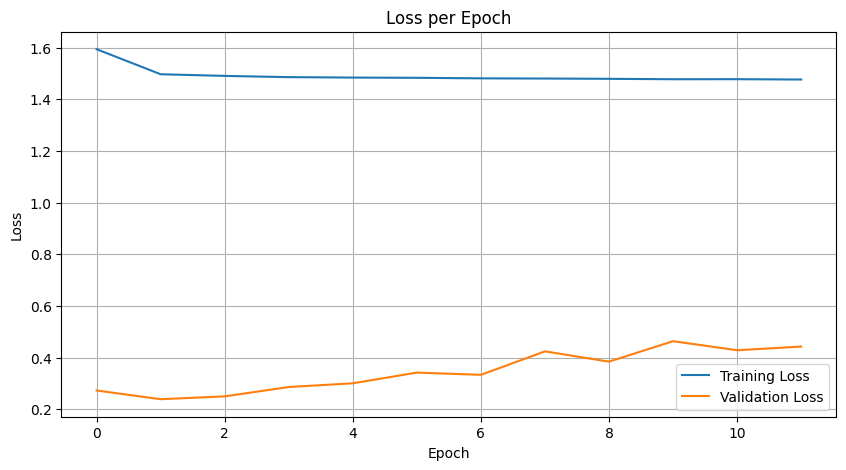

In [ ]:
epoch = train(model=model,
              training_set=mnist_train,
              validation_set=mnist_val,
              num_epochs=100,
              patience=10,
              plot=True,
              device=device)

In [ ]:
# set device for confusion matrix
confusion_mtx = torch.zeros((n_classes, n_classes),
                            dtype=torch.int64, device=device)
model = model.to(device)
for x,y in mnist_val:
  x, y = x.to(device), y.to(device)
  with torch.no_grad():
    y_hat=nn.Softmax()(model(x)).argmax(dim=1)
    for idx, el in enumerate(y):
      confusion_mtx[el,y_hat[idx]]+=1

print(confusion_mtx.sum())
print(confusion_mtx)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor(5000)
tensor([[486,   0,   2,   2,   0,   6,   1,   0,   2,   6],
        [  0, 548,   4,   1,   0,   1,   0,   0,   5,   0],
        [  0,   0, 478,   5,   1,   0,   0,   7,   2,   5],
        [  0,   0,   4, 505,   0,   2,   0,   0,   1,   0],
        [  0,   2,   1,   0, 447,   0,   0,   0,   1,   4],
        [  0,   0,   0,  10,   0, 444,   2,   0,   1,   3],
        [  0,   0,   1,   1,   7,  11, 485,   0,   2,   0],
        [  0,   0,   1,   1,   1,   0,   0, 493,   0,   2],
        [  2,   0,   2,   1,   0,   1,   2,   2, 471,   7],
        [  0,   1,   0,   1,   5,   0,   0,   3,   2, 506]])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filename="/content/drive/MyDrive/cnnautoencoder_model_ckpt.pth"

save_dict={
    "model_state_dict":model.state_dict(),
    "optimizer_state_dict":optimizer.state_dict(),
    "cur_epoch": epoch,
}

torch.save(save_dict,filename)

In [ ]:
data=torch.load(filename)
model.load_state_dict(data["model_state_dict"])
cur_epoch=data["cur_epoch"]

# Assignment: Model Metrics

In [ ]:
class ModelMetrics:
  @staticmethod
  def from_confusion_mtx(confusion_mtx: torch.Tensor, device=None):
    if device == None:
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    mtx = confusion_mtx.to(device)
    num_classes = confusion_mtx.shape[0]

    # From the definition in https://stats.stackexchange.com/a/51301
    results = dict()

    results["precision"] = torch.Tensor([mtx[i,i] / torch.sum(mtx[:,i])
                                         for i in range(num_classes)])
    results["recall"] = torch.Tensor([mtx[i,i] / torch.sum(mtx[i,:])
                                      for i in range(num_classes)])
    results["f1-score"] = 2 * results["precision"] * results["recall"] / (results["precision"] + results["recall"])

    # Accuracy (per-class)
    # Based on https://github.com/pytorch/torcheval/blob/main/torcheval/metrics/functional/classification/accuracy.py
    results["accuracy"] = mtx.diag() / mtx.sum(dim=1)

    return {
        "model": {k: torch.mean(v) for k,v in results.items()},
        "labeled": results
    }

In [ ]:
stats = ModelMetrics.from_confusion_mtx(confusion_mtx)

In [ ]:
num_classes = confusion_mtx.shape[0]

# Pretty Print
headers = list(stats["labeled"].keys())

rows = [[f"{float(stats['labeled'][header][i]):.5f}" for header in headers]
        for i in range(num_classes)]
averages = [f"{float(stats['model'][header]):.5f}" for header in headers]

# Fix length
headers = ["class", *headers]
fmtstr = "  ".join(["{:<10}"] + ["{:<10}" for _ in headers[1:]])
lines = [fmtstr.format(*headers)]
lines.extend([fmtstr.format(idx, *row) for idx, row in enumerate(rows)])
lines.extend([fmtstr.format("Model", *averages)])

# Table Separator
row_sep = f"\n{len(lines[0])*'─'}\n"
print(f"{row_sep[1:]}{row_sep.join(lines)}{row_sep[:-1]}")

──────────────────────────────────────────────────────────
class       precision   recall      f1-score    accuracy  
──────────────────────────────────────────────────────────
0           0.99590     0.96238     0.97885     0.96238   
──────────────────────────────────────────────────────────
1           0.99456     0.98032     0.98739     0.98032   
──────────────────────────────────────────────────────────
2           0.96957     0.95984     0.96468     0.95984   
──────────────────────────────────────────────────────────
3           0.95825     0.98633     0.97209     0.98633   
──────────────────────────────────────────────────────────
4           0.96963     0.98242     0.97598     0.98242   
──────────────────────────────────────────────────────────
5           0.95484     0.96522     0.96000     0.96522   
──────────────────────────────────────────────────────────
6           0.98980     0.95661     0.97292     0.95661   
────────────────────────────────────────────────────────

## Verify Solution

In [ ]:
!pip install torcheval

from torcheval.metrics import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.1 MB/s eta 0:00:00


In [ ]:
# Compare with pytorch metrics
# https://docs.pytorch.org/torcheval/main/torcheval.metrics.html#classification-metrics
num_classes = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

accuracy = MulticlassAccuracy(num_classes=num_classes, average=None).to(device)
precision = MulticlassPrecision(num_classes=num_classes, average=None).to(device)
recall    = MulticlassRecall(num_classes=num_classes, average=None).to(device)
f1_score  = MulticlassF1Score(num_classes=num_classes, average=None).to(device)

model.eval()
with torch.no_grad():
    for inputs, targets in mnist_val:
        inputs, targets = inputs.to(device), targets.to(device)

        logits = model(inputs)
        preds  = logits.argmax(dim=1)

        accuracy.update(preds, targets)
        precision.update(preds, targets)
        recall.update(preds, targets)
        f1_score.update(preds, targets)

results = {
    "accuracy": accuracy.compute(),
    "precision": precision.compute(),
    "recall": recall.compute(),
    "f1-score": f1_score.compute()
}

computed = stats['labeled']

for key, metrics in results.items():
  for i, val in enumerate(metrics):
    if val != (c := computed[key][i]):
      print(f"Implementation error, expected {val} got {c}")

/usr/local/lib/python3.11/dist-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:231.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")
